In [31]:
#Bring in needed packages
import datetime as dt
import pandas as pd
from pandas.tseries.offsets import MonthBegin

import numpy as np
import sqlite3

import plotly.express as px




# First step exploration of Data and understanding datasets

In [98]:
#Explore Customers dataset first

customers = pd.read_csv('~/Downloads/customer.csv')

print(customers.shape)
print(customers.columns)
for column in customers.columns:
    print(customers[column].unique())

print(customers['CUSTOMER_ID'].nunique())
print(customers['CUSTOMER_ID'].count())

#Only two columns - customer id and location.
#All customer_ids are unique meaning we can join without issue
#Location only two values

(1140762, 2)
Index(['CUSTOMER_ID', 'CUSTOMER_COUNTRY'], dtype='object')
['ac4a2a81ecd58d11bca0e61bde3e97be' '2eb3649a35b9d70ccb3946071af5b3f9'
 '15992886b448e1ef51fa3b720aa0b3f6' ... '6c49cbc86f5be6840f3677292b9b5792'
 'c2c0a9da18b6174bc3a5542f9924eac6' '69657de3bb507332b794d849c2720645']
['Brazil' 'United Kingdom']
1140762
1140762


In [99]:
#Explore orders dataset next

orders = pd.read_csv('~/Downloads/acq_order.csv')

print(orders.shape)
print(orders.columns)
for column in orders.columns:
    print(orders[column].unique())

print(orders['CUSTOMER_ID'].nunique())
print(orders['CUSTOMER_ID'].count())
    

#Only two columns - customer id and product. 
#Customer_id unique again allowing easy joins
#Product has 7 options and Null Values

(1140762, 2)
Index(['CUSTOMER_ID', 'TAXONOMY_BUSINESS_CATEGORY_GROUP'], dtype='object')
['dd146dbb03461a8ddeebf963ba64d3ee' '0ea8c224af27adc74f8e3f33ea4772aa'
 '4f165c207a10975490983d33e0d0ae52' ... '7ef07baaf55a52a9323c4ba8c04fdb93'
 '7b7036bb0ff1403076ac07069f485a06' 'c299b916facbf5c32a8656c5561c8c3c']
['Hair Loss Group' 'Weight Loss Group' 'ED Group' 'Other Group'
 'Sleep Group' 'TRT Group' nan 'Mental Health Group']
1140762
1140762


In [100]:
#Explore activity last

activity = pd.read_csv('~/Downloads/activity.csv')

print(activity.shape)
print(activity.columns)
# for column in activity.columns:
#     print(activity[column].unique())

print(activity.head())


print(activity['CUSTOMER_ID'].nunique())
print(activity['CUSTOMER_ID'].count())

#Five columns - snapshot table showing the from_date and to_date of a particular subscription
#Customers can have multiple products within a certain time period
    


(7714042, 5)
Index(['CUSTOMER_ID', 'SUBSCRIPTION_ID', 'FROM_DATE', 'TO_DATE', 'IS_ACTIVE'], dtype='object')
                        CUSTOMER_ID                   SUBSCRIPTION_ID  \
0  02f7baf8fd6e0e64ab7fc8086f00d5dc  7a7a6010aab8af7c9be39a147318e308   
1  ee15e5624c52047c366f4d78e16a9d38  659d310612ed7c9eccc044588bea158a   
2  e5c1744e18ee06806b928a7b9129435f  9c4adb609c4f74bb8b0594550d6ef58a   
3  ff10fa8b46156b3429369cbe66f3f1c4  05cb0e9f3d4dd6cd64c5b4f6383f553f   
4  970eb7cd09ad84016491cb75d9eeb5f9  93f52fc53bde4ada81365d7c2acb0735   

    FROM_DATE     TO_DATE  IS_ACTIVE  
0  2023-12-29  2023-10-31       True  
1  2023-06-03  2023-10-22       True  
2  2023-04-25  2023-07-25       True  
3  2022-02-06  2022-05-07       True  
4  2020-04-02  2020-05-08       True  
618618
7714042


In [101]:
#Explore activity for a user with lots of rows. 
frequent_users = activity.IS_ACTIVE.value_counts() > 1
# print(frequent_users)


## It looks like a single subscription_id can appear multiple times on the same day. 
## It's clear that the activity dataset needs some cleaning.

print(activity[activity['SUBSCRIPTION_ID'] =='0000104cd168386a335ba6bf6e32219d'].sort_values(['FROM_DATE', 'TO_DATE']))

## Sort by from_date, to_date 
## Check if next day is more than current day and drop if so.

                              CUSTOMER_ID                   SUBSCRIPTION_ID  \
4146061  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
3697419  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
7288391  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
2188191  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
497399   211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
965849   211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
4511074  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
103238   211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
375876   211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
5343358  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
502998   211dcf4d9fd0a7693bfe8651fa66482c  0000104cd168386a335ba6bf6e32219d   
7426457  211dcf4d9fd0a7693bfe8651fa66482c  0000104cd

# Data Cleansing 

### We need to do a few steps to clean up the activity data so that it can be joined easily
### Remove any records which occur on the same day - we will take the latest data for each day 
### Once multiple records for same day we can join to customers/orders to get product and region splits
### These would be the final tables as saved in the warehouse - cleaned and each showing a particular purpose. One for activity and one for customers. I will then join them together and create the measures we need in the next step.

In [102]:
# # Order by start_date/to_date so that dataset is orderered correctly
activity = activity.sort_values(['FROM_DATE', 'TO_DATE'])

# # Do a lead function to get the next FROM_DATE over the subscription_id
activity['SHIFTED_FROM_DATE'] = activity.groupby('SUBSCRIPTION_ID')['FROM_DATE'].shift(-1)

# # Drop records that start on same date as next row 
activity_dropped =activity[activity['FROM_DATE'] != activity['SHIFTED_FROM_DATE']]

activity_dropped[activity_dropped['SUBSCRIPTION_ID'] == '2848c23f79860a09ad62084f730e43ef'].head()


,CUSTOMER_ID,SUBSCRIPTION_ID,FROM_DATE,TO_DATE,IS_ACTIVE,SHIFTED_FROM_DATE
6825551,b2414c169b65b7d486a36170d0721cbc,2848c23f79860a09ad62084f730e43ef,2024-02-15,2024-02-16,False,2024-02-16
1591618,b2414c169b65b7d486a36170d0721cbc,2848c23f79860a09ad62084f730e43ef,2024-02-16,2024-02-17,False,2024-02-17
7683659,b2414c169b65b7d486a36170d0721cbc,2848c23f79860a09ad62084f730e43ef,2024-02-17,2024-02-18,False,2024-02-18
420689,b2414c169b65b7d486a36170d0721cbc,2848c23f79860a09ad62084f730e43ef,2024-02-18,2024-02-19,False,2024-02-19
2412655,b2414c169b65b7d486a36170d0721cbc,2848c23f79860a09ad62084f730e43ef,2024-02-19,2024-02-20,False,2024-02-20


In [103]:
## Now we should reduce the rows to only those where theres actually a valid change 

activity_dropped['SHIFTED_IS_ACTIVE'] = activity_dropped.groupby('SUBSCRIPTION_ID')['IS_ACTIVE'].shift(1)

activity_dropped['CHANGE_FLAG'] = activity_dropped['IS_ACTIVE'] != activity_dropped['SHIFTED_IS_ACTIVE']

activity_cleaned = activity_dropped[(activity_dropped['CHANGE_FLAG'])]

# Replace original to_date with lead function 
activity_cleaned['TO_DATE'] = activity_cleaned.groupby('SUBSCRIPTION_ID')['FROM_DATE'].shift(-1)

# Replace NULL to_date with current_date 
current_date  = dt.datetime.today().strftime('%Y-%m-%d')
activity_cleaned['TO_DATE'] = activity_cleaned['TO_DATE'].fillna(current_date)

activity_final = activity_cleaned.drop(columns = ['SHIFTED_FROM_DATE', 'SHIFTED_IS_ACTIVE', 'CHANGE_FLAG'])

activity_final.to_csv('activity_cleaned.csv')


/var/folders/3w/9mjb7xvj25g6gp3jvgwgtp400000gn/T/ipykernel_2416/1441145782.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3w/9mjb7xvj25g6gp3jvgwgtp400000gn/T/ipykernel_2416/1441145782.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3w/9mjb7xvj25g6gp3jvgwgtp400000gn/T/ipykernel_2416/1441145782.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [104]:
## Create customer table with enhanced metrics 

customers_enhanced = customers.join(orders.set_index('CUSTOMER_ID'), on='CUSTOMER_ID', how='left')

# Get other dimensions for customers table from orders table 
customer_join_date = activity_final.groupby('CUSTOMER_ID').FROM_DATE.agg('min')
customers_enhanced = customers_enhanced.join(customer_join_date, on='CUSTOMER_ID', how='left')

customer_subscription_count = activity_final.groupby('CUSTOMER_ID').SUBSCRIPTION_ID.agg(pd.Series.nunique)
customers_enhanced = customers_enhanced.join(customer_subscription_count, on='CUSTOMER_ID', how='left')


customers_enhanced = customers_enhanced.rename(columns={"FROM_DATE": "CUSTOMER_FIRST_ACTIVE_DATE","SUBSCRIPTION_ID": "CUSTOMER_SUBSCRIPTION_COUNT"} )

customers_enhanced.to_csv('customers_enhanced_dimension_table.csv')


In [106]:
# Finally create a date table which can be used in BI layer for joining purposes. 

earliest_customer_join_date = activity_final['FROM_DATE'].agg('min')
date_range = pd.DataFrame({'CALENDAR_MONTH':pd.date_range(start=earliest_customer_join_date,end='2024-08-01', freq='MS')})
date_range['NEXT_CALENDAR_MONTH'] = date_range['CALENDAR_MONTH'].shift(-1)
date_range.to_csv('date_table.csv')


# Creating BI Visualisation Layer

### Here we join together the cleaned tables and create a view for reporting purposes

### I attempted a few different versions of this and kept running into memory issues. 
### For performance purposes I have aggregated things to a monthly granularity but this could also be viewed at a weekly/daily level depending on business requirements. 

In [107]:


#Joining on the day is causing memory issues so we will have to do a monthly view

activity_final['TO_DATE_MONTH'] = pd.to_datetime(activity_final['TO_DATE']) - pd.offsets.MonthEnd(0) - MonthBegin(1)
activity_final['FROM_DATE_MONTH'] = pd.to_datetime(activity_final['FROM_DATE']) - pd.offsets.MonthEnd(0)  - MonthBegin(1)
customers_enhanced['CUSTOMER_FIRST_ACTIVE_MONTH'] = pd.to_datetime(customers_enhanced['CUSTOMER_FIRST_ACTIVE_DATE']) - pd.offsets.MonthEnd(0)  - MonthBegin(1)


#Using sqllite databases as it is easier to join than using pandas as I did in the data cleaning process
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
date_range.to_sql('date_range', conn, index=False)
activity_final.to_sql('activity', conn, index=False)
customers_enhanced.to_sql('customers', conn, index=False)

sql2 = "CREATE INDEX todate_idx ON activity (TO_DATE);"
conn.execute(sql2)
sql3 = "CREATE INDEX fromdate_idx ON activity (FROM_DATE);"
conn.execute(sql3)



In [108]:
#We can now join our customers_enhanced dataset to activity
#We know that the customer_id is unique in customers so this can be a simple left join
#We can also filter down the dataset to just where people are active to reduce row counts for processing

sqlcode = '''
   SELECT
       activity.*
       , customers.TAXONOMY_BUSINESS_CATEGORY_GROUP
       , customers.CUSTOMER_FIRST_ACTIVE_MONTH
       , customers.CUSTOMER_SUBSCRIPTION_COUNT
   FROM activity
   LEFT JOIN customers 
       ON activity.customer_id = customers.customer_id
    WHERE IS_ACTIVE
'''

test_table = pd.read_sql_query(sqlcode, conn)
test_table
test_table.to_sql('activity_filtered', conn, index=False)

1563940

In [110]:
## Create the final table where we combine both the Customer data with activity
## We can group this up so that we are simply counting per customer per month. I wanted to try this at the subscription level also but was running
## into memory issues.

sqlcode = '''
    WITH activity_filtered_further AS (
        SELECT 
            TO_DATE_MONTH
            , FROM_DATE_MONTH
            , TAXONOMY_BUSINESS_CATEGORY_GROUP
            , CUSTOMER_FIRST_ACTIVE_MONTH
            , CUSTOMER_ID
        FROM activity_filtered
        GROUP BY 1,2,3,4,5
    )
    SELECT
       date_range.CALENDAR_MONTH
       , TAXONOMY_BUSINESS_CATEGORY_GROUP
       , CUSTOMER_FIRST_ACTIVE_MONTH
       , CUSTOMER_ID
   FROM date_range
   LEFT JOIN activity_filtered_further 
       -- gives people active over month
        ON (date_range.CALENDAR_MONTH <= activity_filtered_further.TO_DATE_MONTH
        AND date_range.CALENDAR_MONTH >= activity_filtered_further.FROM_DATE_MONTH) 
    GROUP BY 1,2,3,4
      '''


final_table = pd.read_sql_query(sqlcode, conn)
final_table


,CALENDAR_MONTH,TAXONOMY_BUSINESS_CATEGORY_GROUP,CUSTOMER_FIRST_ACTIVE_MONTH,CUSTOMER_ID
0,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,006f52e9102a8d3be2fe5614f42ba989
1,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,019d385eb67632a7e958e23f24bd07d7
2,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,04ecb1fa28506ccb6f72b12c0245ddbc
3,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,06409663226af2f3114485aa4e0a23b4
4,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,07563a3fe3bbe7e3ba84431ad9d055af
...,...,...,...,...
9413507,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffcae5c25d262384ebbbfa4ee386223e
9413508,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffd2797fb1a6170b584f826542538e1f
9413509,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffe6208cf542a6207e7deca1fdcfb1b7
9413510,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffea619e047b4b186fc7ce46fa1ed2eb


In [111]:
# Get month difference for charts
final_table['MONTH_DIFFERENCE'] = round((pd.to_datetime(final_table.CALENDAR_MONTH) - pd.to_datetime(final_table.CUSTOMER_FIRST_ACTIVE_MONTH)) / np.timedelta64(1, 'D')/30)
final_table

,CALENDAR_MONTH,TAXONOMY_BUSINESS_CATEGORY_GROUP,CUSTOMER_FIRST_ACTIVE_MONTH,CUSTOMER_ID,MONTH_DIFFERENCE
0,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,006f52e9102a8d3be2fe5614f42ba989,1.0
1,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,019d385eb67632a7e958e23f24bd07d7,1.0
2,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,04ecb1fa28506ccb6f72b12c0245ddbc,1.0
3,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,06409663226af2f3114485aa4e0a23b4,1.0
4,2019-02-01 00:00:00,ED Group,2019-01-01 00:00:00,07563a3fe3bbe7e3ba84431ad9d055af,1.0
...,...,...,...,...,...
9413507,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffcae5c25d262384ebbbfa4ee386223e,1.0
9413508,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffd2797fb1a6170b584f826542538e1f,1.0
9413509,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffe6208cf542a6207e7deca1fdcfb1b7,1.0
9413510,2024-07-01 00:00:00,Weight Loss Group,2024-06-01 00:00:00,ffea619e047b4b186fc7ce46fa1ed2eb,1.0


/Users/josh/.local/share/virtualenvs/Python_Projects-sX2dV-qo/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



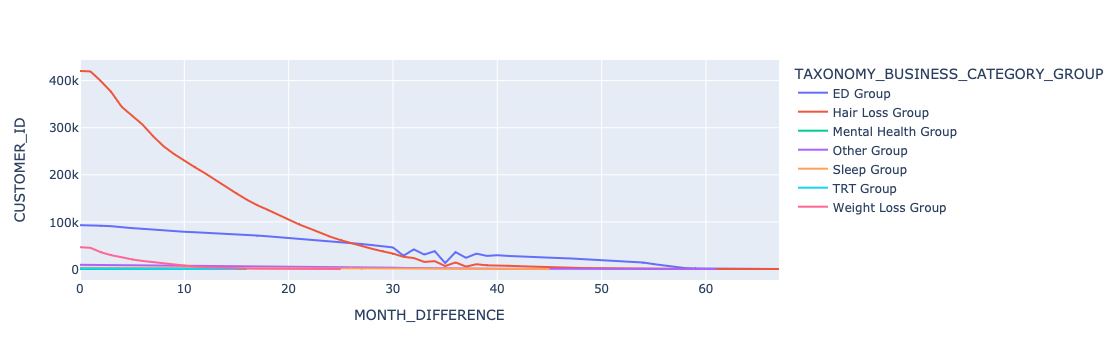

In [113]:
##Draw some retention curves for easy analysis across products

taxonomy_grouping = final_table.groupby(by=["TAXONOMY_BUSINESS_CATEGORY_GROUP", "MONTH_DIFFERENCE"], dropna=False).CUSTOMER_ID.nunique()
taxonomy_grouping = taxonomy_grouping.reset_index()
# taxonomy_grouping
fig = px.line(taxonomy_grouping, x="MONTH_DIFFERENCE", y="CUSTOMER_ID", color='TAXONOMY_BUSINESS_CATEGORY_GROUP')
fig.show()


/Users/josh/.local/share/virtualenvs/Python_Projects-sX2dV-qo/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



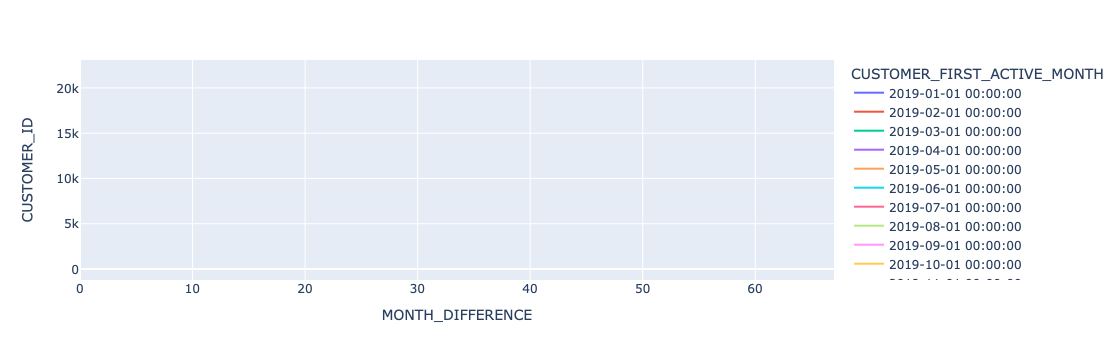

In [122]:
month_grouping = final_table.groupby(by=["CUSTOMER_FIRST_ACTIVE_MONTH", "MONTH_DIFFERENCE"], dropna=False).CUSTOMER_ID.nunique()
month_grouping = month_grouping.reset_index()
fig = px.line(month_grouping, x="MONTH_DIFFERENCE", y="CUSTOMER_ID", color='CUSTOMER_FIRST_ACTIVE_MONTH')
fig.show()


/Users/josh/.local/share/virtualenvs/Python_Projects-sX2dV-qo/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



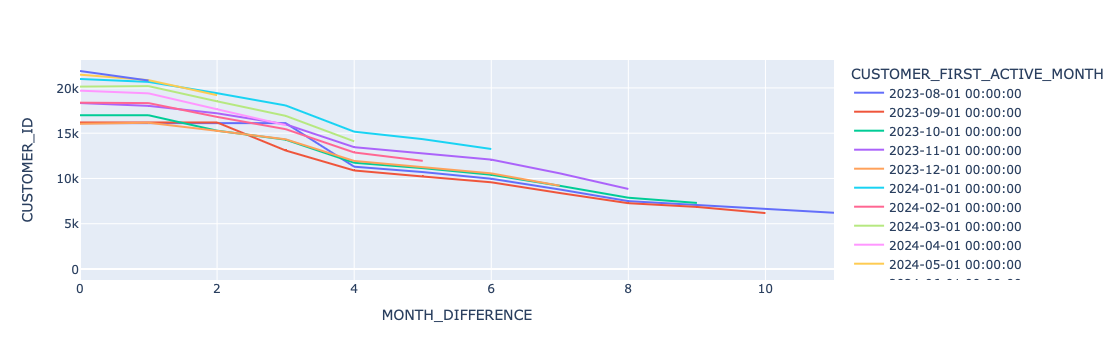

/Users/josh/.local/share/virtualenvs/Python_Projects-sX2dV-qo/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



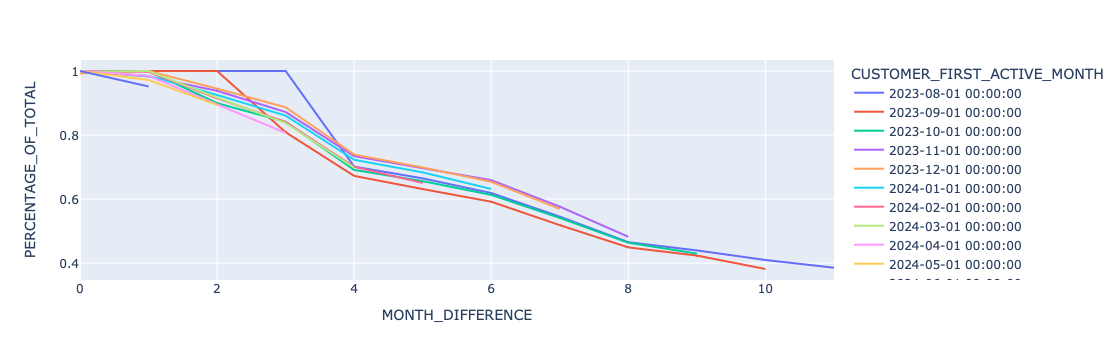

In [128]:

##Draw some retention curves for easy analysis across cohorts

## Just show last year for cleaner retention curves 
month_grouping = month_grouping[month_grouping['CUSTOMER_FIRST_ACTIVE_MONTH'] >= '2023-08-01 00:00:00']
fig = px.line(month_grouping, x="MONTH_DIFFERENCE", y="CUSTOMER_ID", color='CUSTOMER_FIRST_ACTIVE_MONTH')
fig.show()


month_grouping['PERCENTAGE_OF_TOTAL'] = month_grouping['CUSTOMER_ID'] / month_grouping.groupby('CUSTOMER_FIRST_ACTIVE_MONTH')['CUSTOMER_ID'].transform('max')
fig = px.line(month_grouping, x="MONTH_DIFFERENCE", y="PERCENTAGE_OF_TOTAL", color='CUSTOMER_FIRST_ACTIVE_MONTH')
fig.show()
